### Importing the necessary Libraries

In [1]:
%matplotlib inline
import os

import numpy as np
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from PIL import Image
import matplotlib.pyplot as plt

#### Processing the nuscenes mini data, by interacting with its database

In [2]:
nusc = NuScenes(version="v1.0-mini", dataroot="data/sets/nuscenes", verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.258 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [3]:
# Taking a scene at index 0 as example and plot a 3d bounding box with all the transformation
# On to an image
sample_scene = nusc.scene[0]
sample_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [5]:
# Fetch the annotation for this particular scene
sample = nusc.get("sample", sample_scene["first_sample_token"])

# For this tutorial we'll be taking CAMFRONT data
# Which is the front facing data
sensor = "CAM_FRONT"
cam_front_data = nusc.get("sample_data", sample['data'][sensor])

# Fetch the annotation of a truck in the scene
annotation = nusc.get("sample_annotation", sample["anns"][18])
annotation

{'token': '83d881a6b3d94ef3a3bc3b585cc514f8',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': 'e91afa15647c4c4994f19aeb302c7179',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [409.989, 1164.099, 1.623],
 'size': [2.877, 10.201, 3.595],
 'rotation': [-0.5828819500503033, 0.0, 0.0, 0.812556848660791],
 'prev': '',
 'next': 'f3721bdfd7ee4fd2a4f94874286df471',
 'num_lidar_pts': 495,
 'num_radar_pts': 13,
 'category_name': 'vehicle.truck'}

##### Get the Camera intrinsic and other parameters for perspective projection

In [10]:
# Get the image path
image_path = cam_front_data["filename"]

In [11]:
image_path

'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg'

#### Fetch Camera Related Information

In [16]:
# Get camera related information
# The Information is Camera intrinsic (Need to project 3d points to 2d image)
# Translation, it is the position of camera in ego vehicle coordinate system
# Rotation, it is the rotation of camera in ego vehicle coordinate system
calibrated_sensor = nusc.get(
    "calibrated_sensor", cam_front_data["calibrated_sensor_token"]
)
camera_intrinsic = np.array(calibrated_sensor["camera_intrinsic"])
camera_translation = np.array(calibrated_sensor["translation"])
camera_rotation = np.array(calibrated_sensor["rotation"])

height, width = cam_front_data["height"], cam_front_data["width"]

##### Fetch Ego Vehicle Related Information

In [17]:
# Get the ego vehicle related information
# Translation, it is the position of ego vehicle in global coordinate system
# Rotation, it is the rotation of ego vehicle in global coordinate system
pose = nusc.get("ego_pose", cam_front_data["ego_pose_token"])
vehicle_translation = np.array(pose["translation"])
vehicle_rotation = np.array(pose["rotation"])

##### Get the annotation Related information of a truck in CAM FRONT Image

In [18]:
size = annotation["size"]
rotation = annotation["rotation"]
translation = annotation["translation"]
category_name = annotation["category_name"]

### Visualizing the 3d Coordinates

##### The Flow for Visualizing 3d Coordinates on a 2d Image is as follows:

-> Translate the center of the box to convert it into vehicle coordinate system
    
    *> Subtract Vehicle's translation Matrix with box's

    *> Multiply Quaternion inverse of ego vehicle's rotation matrix (as non inverse rotation converts a coordinate from vehicle's cooridinate system to global coordinate system, so the inverse of it will do the inverse operation on a vector present in the global coordinate system)

-> Do the same for Camera's params as we want to get coordinates from vehicle's system to camera's system

In [19]:
# Perform all the processing in the camera coordinate system
## Bounding box parameters
center = np.array(translation)
size = size
orientation = Quaternion(rotation)
category_name = category_name

In [20]:
# Move the coordinate system to the vehicle coordinate system
# translate the center of the bounding box relative to the ego vehicle
center_ego = center - vehicle_translation

# Rotate the bbox relative to the ego vehicle
ego_vehicle_rotation_quat = Quaternion(vehicle_rotation).inverse
center_ego = np.dot(ego_vehicle_rotation_quat.rotation_matrix, center_ego)
orientation_ego = orientation * ego_vehicle_rotation_quat

# Move the coordinate system to the camera coordinate system
# translate the center
center_camera = center_ego - camera_translation

# Rotate the bbox relative to camera
sensor_rotation_quat = Quaternion(camera_rotation).inverse
center_camera = np.dot(sensor_rotation_quat.rotation_matrix, center_camera)
orientation_camera = orientation_ego * sensor_rotation_quat

*> Get 8 corners of the bbox and rotate the box using the orientation_camera, which is the orientation of the box in the camera coordinate system

In [21]:
# Fetch the 8 corners of the bounding box
# 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
width, length, height = size

# 2^3=> 8 corners as the bounding box is in 3D space for some corners some dimensions have to be added and for some subtracted
# from the the center of the bounding box
# This from the origin (0,0,0)
x_corners = length / 2 * np.array([1, 1, 1, 1, -1, -1, -1, -1])
y_corners = width / 2 * np.array([1, -1, -1, 1, 1, -1, -1, 1])
z_corners = height / 2 * np.array([1, 1, -1, -1, 1, 1, -1, -1])
corners = np.vstack((x_corners, y_corners, z_corners))

# Rotate the box using orientation_camera
corners = np.dot(orientation_camera.rotation_matrix, corners)

# Translate the corners to the bbox center
x, y, z = center_camera
corners[0, :] += x
corners[1, :] += y
corners[2, :] += z

In [22]:
# Perform Perspective Projection of these 8 boxes
# We need 4x4 matrix for the projection

view_pad = np.eye(4)
view_pad[:3, :3] = camera_intrinsic

# Make it (x, y, z, 1) ## TODO: Need to learn the underlying math (probably due to view_pad being 4 * 4)
points = np.concatenate((corners, np.ones((1, corners.shape[1]))), axis=0)

# Apply the transformation
points = np.dot(view_pad, points)

# The 3d corners
points_camera = points[:3]
points_camera.shape

# Normalize the points with depth to avoid distortion in perspective projection
# TODO: Need to learn the underlying math
# Check without this visualization
points_camera /= points_camera[2]

(900.0, 0.0)

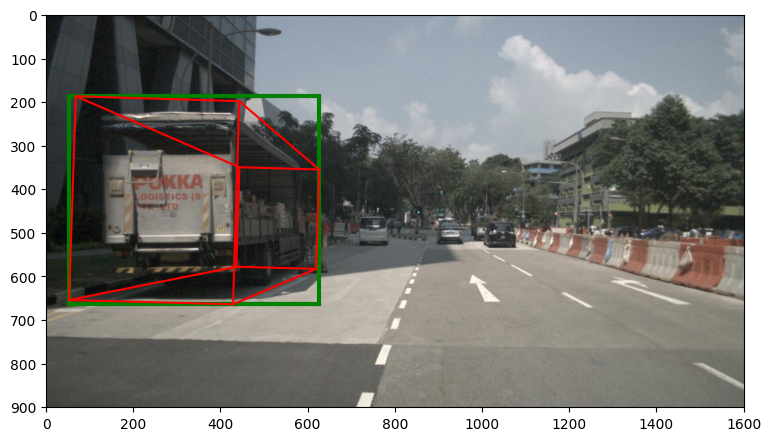

In [23]:
# Visualize the box in the image
_, ax = plt.subplots(1, 1, figsize=(9, 16))

image = Image.open(os.path.join("data/sets/nuscenes", image_path))
ax.imshow(image)

# Code to visualiza the 3D bounding box
corner_points = points_camera.T  ## To make it (8, 3) easier to iterate

# Basically draw lines between the corners just in z direction
# Coordinates are stored in clockwise order
for i in range(4):
    ax.plot(
        [corner_points[i, 0], corner_points[i + 4, 0]],
        [corner_points[i, 1], corner_points[i + 4, 1]],
        color="r",
    )

# Draw the front facing box
front_boxes = corner_points[4:]

prev = front_boxes[-1]
for bboxes in front_boxes:
    ax.plot([prev[0], bboxes[0]], [prev[1], bboxes[1]], color="r")
    prev = bboxes

# Draw the back facing box
back_boxes = corner_points[:4]

prev = back_boxes[-1]
for bboxes in back_boxes:
    ax.plot([prev[0], bboxes[0]], [prev[1], bboxes[1]], color="r")
    prev = bboxes


# Get 2d bbox
min_x = np.min(corner_points[:, 0])
max_x = np.max(corner_points[:, 0])
min_y = np.min(corner_points[:, 1])
max_y = np.max(corner_points[:, 1])

# Plot a rectangle
ax.add_patch(
    plt.Rectangle(
        (min_x, min_y),
        max_x - min_x,
        max_y - min_y,
        fill=False,
        edgecolor="g",
        linewidth=3,
    )
)

ax.set_xlim(0, image.size[0])
ax.set_ylim(image.size[1], 0)